# CIFAR10 Convolutional Neural Network With Residual Connections Augmented

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils
from tensorflow.keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tf.get_logger().setLevel('ERROR')
train_data, test_data = tfds.load('cifar10', split=['train', 'test'])
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [2]:
def transform(elm):
    return (tf.cast(elm['image'], tf.float32) / 255, tf.one_hot(elm['label'], 10))
train_validation_data = train_data.map(transform, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = train_validation_data.shard(10, 9)
validation_data = validation_data.batch(64)
validation_data = validation_data.cache() 
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)
train_data = train_validation_data.shard(10, 8)
for i in range(8):
    train_data = train_data.concatenate(train_validation_data.shard(10, i))
train_data = train_data.cache()
train_data = train_data.shuffle(len(train_data))
train_data = train_data.batch(64)
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(
    transform, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(64)
test_data = test_data.cache()
test_data = test_data.prefetch(tf.data.AUTOTUNE)

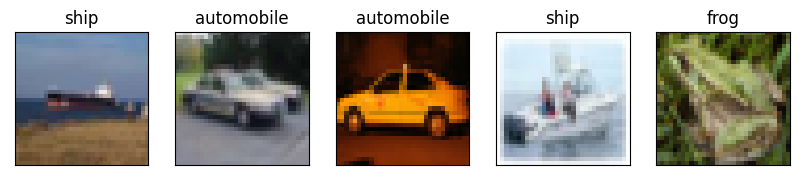

In [3]:
imgs, labels = train_data.as_numpy_iterator().next()
plt.figure(figsize=(10,10)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[i], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[np.argmax(labels[i])])
plt.show()

In [4]:
data = tf.keras.Sequential([layers.RandomRotation(0.3),layers.RandomFlip(mode='horizontal')])
train = train_data.map(lambda x, y: (data(x, training=True), y),num_parallel_calls=tf.data.AUTOTUNE)
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)
def res_net():
    input_layer = Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
    y = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
    xy = Add()([x,y])
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(xy)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    t = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
    y = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(t)
    ty = Add()([t,y])
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(ty)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    return tf.keras.Model(inputs=input_layer, outputs=x, name='res_net')
model = res_net()
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train,validation_data=validation_data,epochs=100,verbose=0)

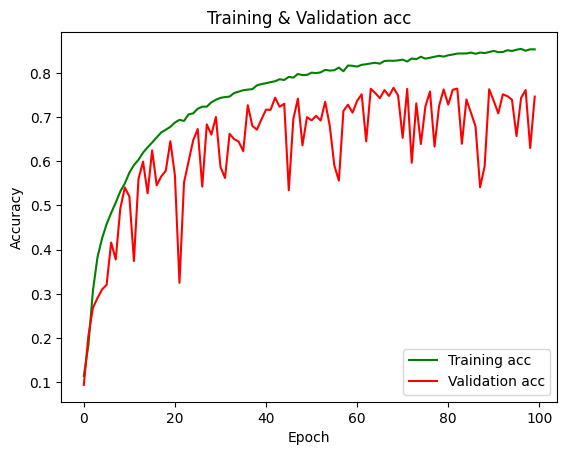

<Figure size 640x480 with 0 Axes>

157/157 [==============================] - 1s 8ms/step - loss: 0.8689 - accuracy: 0.7422


{'loss': 0.8688982129096985, 'accuracy': 0.7422000169754028}

In [5]:
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], 'g-', label='Training acc')
plt.plot(range(len(history.history['accuracy'])), history.history['val_accuracy'], 'r-', label='Validation acc')
plt.title('Training & Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.legend(loc='lower right')
plt.figure()
plt.show()
model.evaluate(test_data, return_dict=True)